# Drilling Activity Prediction: Data Modeling - ARIMA

- Import dataset and resample to monthly data
- Use oil dataset to predict oil rig count:
    - Find what hyperparameters to be used in the model (p,d,q)
    - Train/test split
    - Create ARIMA model and fit with data
    - Generate Forecast and compare against Test set
    - Evaluation Measures
    - Refit the model with 100% of data and make REAL Forecasting    
    
    
 - Create ARIMA model with Gas dataframe to predict Gas Rig Count

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load specific forecasting tools
from statsmodels.tsa.arima.model import ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse, mse, meanabs
from sklearn.model_selection import TimeSeriesSplit
import time
from pmdarima import auto_arima
from pylab import rcParams

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Size of all plots
rcParams['figure.figsize'] = 6,6

In [2]:
dfoil = pd.read_csv('dfoil.csv',index_col=0,parse_dates=True)
dfoil = dfoil.resample('M').mean()
dfoil.index.freq = 'M'


dfgas = pd.read_csv('dfgas.csv',index_col=0,parse_dates=True)
dfgas = dfgas.resample('M').mean()
dfgas.index.freq = 'M'

Before we can apply an ARIMA forecasting model, we need to review the components of one.<br>
ARIMA, or Autoregressive Independent Moving Average is actually a combination of 3 models:
* <strong>AR(p)</strong> Autoregression - a regression model that utilizes the dependent relationship between a current observation and observations over a previous period.
* <strong>I(d)</strong> Integration - uses differencing of observations (subtracting an observation from an observation at the previous time step) in order to make the time series stationary
* <strong>MA(q)</strong> Moving Average - a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.


In [3]:
nobs = 12

In [4]:
stepwise_fit = auto_arima(dfoil['oilrig_count'], start_p=0, start_q=0,
                          max_p=6, max_q=3, m=nobs,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2965.143, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2964.110, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2595.587, Time=0.44 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2962.119, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2595.900, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=2596.893, Time=1.05 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2597.400, Time=1.05 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2595.435, Time=0.51 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=2597.316, Time=1.23 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=2599.051, Time=1.40 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=2963.810, Time=0.28 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=2496.812, Time=0.59 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=2498.442, Time=0.21 sec
 ARIMA(2,1,0)(1,0,1)[12]

It looks like the order (3,1,1) is recommended for oil df.

#### Train/test split

- We will evaluate the model forecasting 12 months ahead (1 year)
- Train test split. Test df will have 12 data points

In [5]:
train = dfoil.iloc[:len(dfoil)-nobs]
test = dfoil.iloc[len(dfoil)-nobs:]

#### Fit ARIMA model

In [6]:
oil_model = ARIMA(train['oilrig_count'],order=(3,1,1))
oil_results = oil_model.fit()

#### Generate Forecast values and plot results

In [7]:
#12 months forecast
start=len(train)
end=len(train)+len(test)-1
oil_predictions = oil_results.predict(start=start, end=end, dynamic=False, typ='levels').rename('Oil Rig Count ARIMA(3,1,1) Predictions')

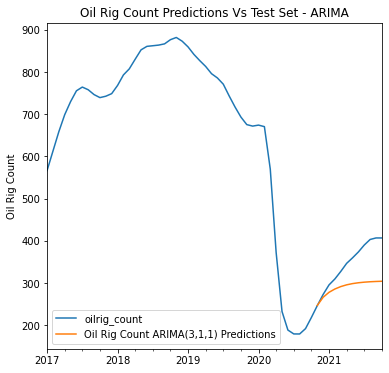

In [8]:
# Plot predictions against known values
title = 'Oil Rig Count Predictions Vs Test Set - ARIMA'
ylabel='Oil Rig Count'
xlabel=''

ax = dfoil['oilrig_count'].loc['2017':].plot(legend=True,title=title)
oil_predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

#### Evaluation Metrics

In [9]:
RMSE1 = rmse(dfoil['oilrig_count'].loc[test.index.min():],oil_predictions)
MSE1 = mse(dfoil['oilrig_count'].loc[test.index.min():],oil_predictions)
MAE1 = meanabs(dfoil['oilrig_count'].loc[test.index.min():],oil_predictions)

print(f"""Oil Rig ARIMA(3,1,1) RMSE: {RMSE1:.3f}
Oil Rig ARIMA(3,1,1) MSE: {MSE1:.3f}
Oil Rig ARIMA(3,1,1) MAE: {MAE1:.3f}\n
Oil Rig Mean Value: {dfoil['oilrig_count'][-nobs:].mean():.3f}
Oil Rig std Value: {dfoil['oilrig_count'][-nobs:].std():.3f}
Oil Rig Percent Change: {RMSE1/dfoil['oilrig_count'][-nobs:].mean()*100:.3f}%""")

Oil Rig ARIMA(3,1,1) RMSE: 66.322
Oil Rig ARIMA(3,1,1) MSE: 4398.668
Oil Rig ARIMA(3,1,1) MAE: 55.252

Oil Rig Mean Value: 345.055
Oil Rig std Value: 54.791
Oil Rig Percent Change: 19.221%


In [10]:
tscv = TimeSeriesSplit(n_splits=10, test_size=12)
RMSE_oil = []
MSE_oil = []
MAE_oil = []
for train_index, test_index in tscv.split(dfoil['oilrig_count']):
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    train, test = dfoil['oilrig_count'][train_index], dfoil['oilrig_count'][test_index]
    oil_model = ARIMA(train,order=(3,1,1))
    oil_results = oil_model.fit()
    start=len(train)
    end=len(train)+len(test)-1
    oil_predictions = oil_results.predict(start=start, end=end, dynamic=False, typ='levels')   
    RMSE_oil.append('{:.3f}'.format(rmse(dfoil.loc[dfoil.index[test_index],'oilrig_count'],oil_predictions)))
    MSE_oil.append('{:.3f}'.format(mse(dfoil.loc[dfoil.index[test_index],'oilrig_count'],oil_predictions)))
    MAE_oil.append('{:.3f}'.format(meanabs(dfoil.loc[dfoil.index[test_index],'oilrig_count'],oil_predictions)))

RMSE_oil = np.array(RMSE_oil).astype('float')
MSE_oil = np.array(MSE_oil).astype('float')
MAE_oil = np.array(MAE_oil).astype('float')
print(f"""\n10-fold Cross Validation Oil Rig
RMSE: {RMSE_oil.mean():.3f}
MSE: {MSE_oil.mean():.3f}
MAE: {MAE_oil.mean():.3f}\n
Oil Rig Mean Value: {dfoil['oilrig_count'][-nobs:].mean():.3f}
Oil Rig std Value: {dfoil['oilrig_count'][-nobs:].std():.3f}
Oil Rig Percent Change: {RMSE_oil.mean()/dfoil['oilrig_count'][-nobs:].mean()*100:.3f}%""")

TRAIN: 178 TEST: 12
TRAIN: 190 TEST: 12
TRAIN: 202 TEST: 12
TRAIN: 214 TEST: 12
TRAIN: 226 TEST: 12
TRAIN: 238 TEST: 12
TRAIN: 250 TEST: 12
TRAIN: 262 TEST: 12
TRAIN: 274 TEST: 12
TRAIN: 286 TEST: 12

10-fold Cross Validation Oil Rig
RMSE: 195.867
MSE: 77269.604
MAE: 170.945

Oil Rig Mean Value: 345.055
Oil Rig std Value: 54.791
Oil Rig Percent Change: 56.764%


#### Fit Model with 100% of Data and forecast Real Future

In [11]:
startTime = time.time()
oil_model = ARIMA(dfoil['oilrig_count'],order=(3,1,1))
oil_results = oil_model.fit()

In [12]:
start=len(dfoil)
end=len(dfoil)+nobs
oil_predictions = oil_results.predict(start=start, end=end, dynamic=False, typ='levels').rename('Oil Rig Count ARIMA(3,1,1) Predictions')
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

Execution time in seconds: 0.2573118209838867


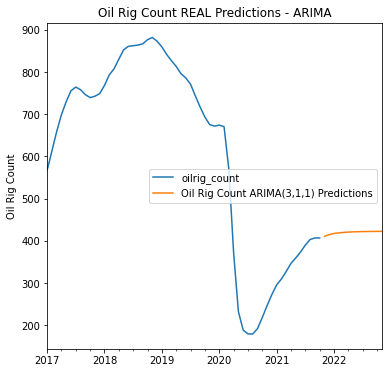

In [13]:
# Plot predictions against known values
title = 'Oil Rig Count REAL Predictions - ARIMA'
ylabel='Oil Rig Count'
xlabel=''

ax = dfoil['oilrig_count'].loc['2017':].plot(legend=True,title=title)
oil_predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

#### Create model with Gas Rig Counts

In [14]:
stepwise_fit = auto_arima(dfgas['gasrig_count'], start_p=0, start_q=0,
                          max_p=6, max_q=3, m=nobs,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2856.211, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2853.367, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2446.106, Time=0.44 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2507.177, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2851.947, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2445.238, Time=0.07 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2446.116, Time=0.38 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.29 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=2388.371, Time=0.20 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=2389.692, Time=0.65 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=2389.608, Time=0.57 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=2391.395, Time=1.11 sec
 ARIMA(3,1,0)(0,0,0)[12] intercept   : AIC=2380.127, Time=0.29 sec
 ARIMA(3,1,0)(1,0,0)[12] intercept   : AIC=2381.190, Time=0.67 sec
 ARIMA(3,1,0)(0,0,1)[12]

In [15]:
train = dfgas.iloc[:len(dfgas)-nobs]
test = dfgas.iloc[len(dfgas)-nobs:]
gas_model = ARIMA(train['gasrig_count'],order=(4,1,1))
gas_results = gas_model.fit()

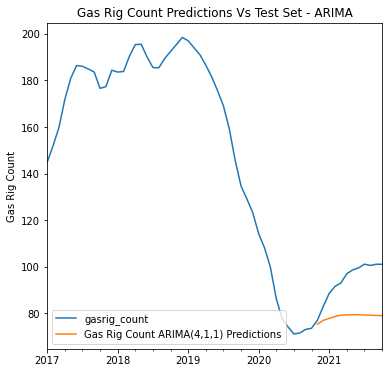

In [16]:
start=len(train)
end=len(train)+len(test)-1
gas_predictions = gas_results.predict(start=start, end=end, dynamic=False, typ='levels').rename('Gas Rig Count ARIMA(4,1,1) Predictions')
# Plot predictions against known values
title = 'Gas Rig Count Predictions Vs Test Set - ARIMA'
ylabel='Gas Rig Count'
xlabel=''

ax = dfgas['gasrig_count'].loc['2017':].plot(legend=True,title=title)
gas_predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [17]:
RMSE2 = rmse(dfgas['gasrig_count'].loc[test.index.min():],gas_predictions)
MSE2 = mse(dfgas['gasrig_count'].loc[test.index.min():],gas_predictions)
MAE2 = meanabs(dfgas['gasrig_count'].loc[test.index.min():],gas_predictions)

print(f"""Gas Rig ARIMA(4,1,1) RMSE: {RMSE2:.3f}
Gas Rig ARIMA(4,1,1) MSE: {MSE2:.3f}
Gas Rig ARIMA(4,1,1) MAE: {MAE2:.3f}\n
Gas Rig Mean Value: {dfgas['gasrig_count'][-nobs:].mean():.3f}
Gas Rig std Value: {dfgas['gasrig_count'][-nobs:].std():.3f}
Gas Rig Percent Change: {RMSE2/dfgas['gasrig_count'][-nobs:].mean()*100:.3f}%""")

Gas Rig ARIMA(4,1,1) RMSE: 17.085
Gas Rig ARIMA(4,1,1) MSE: 291.883
Gas Rig ARIMA(4,1,1) MAE: 15.785

Gas Rig Mean Value: 94.254
Gas Rig std Value: 7.984
Gas Rig Percent Change: 18.126%


In [19]:
tscv = TimeSeriesSplit(n_splits=10, test_size=12)
RMSE_gas = []
MSE_gas = []
MAE_gas = []
for train_index, test_index in tscv.split(dfgas['gasrig_count']):
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    train, test = dfgas['gasrig_count'][train_index], dfgas['gasrig_count'][test_index]
    gas_model = ARIMA(train,order=(3,1,1))
    gas_results = gas_model.fit()
    start=len(train)
    end=len(train)+len(test)-1
    gas_predictions = gas_results.predict(start=start, end=end, dynamic=False, typ='levels')   
    RMSE_gas.append('{:.3f}'.format(rmse(dfgas.loc[dfgas.index[test_index],'gasrig_count'],gas_predictions)))
    MSE_gas.append('{:.3f}'.format(mse(dfgas.loc[dfgas.index[test_index],'gasrig_count'],gas_predictions)))
    MAE_gas.append('{:.3f}'.format(meanabs(dfgas.loc[dfgas.index[test_index],'gasrig_count'],gas_predictions)))

RMSE_gas = np.array(RMSE_gas).astype('float')
MSE_gas = np.array(MSE_gas).astype('float')
MAE_gas = np.array(MAE_gas).astype('float')
print(f"""\n10-fold Cross Validation Gas Rig
RMSE: {RMSE_gas.mean():.3f}
MSE: {MSE_gas.mean():.3f}
MAE: {MAE_gas.mean():.3f}\n
Gas Rig Mean Value: {dfgas['gasrig_count'][-nobs:].mean():.3f}
Gas Rig std Value: {dfgas['gasrig_count'][-nobs:].std():.3f}
Gas Rig Percent Change: {RMSE_gas.mean()/dfgas['gasrig_count'][-nobs:].mean()*100:.3f}%""")

TRAIN: 178 TEST: 12
TRAIN: 190 TEST: 12
TRAIN: 202 TEST: 12
TRAIN: 214 TEST: 12
TRAIN: 226 TEST: 12
TRAIN: 238 TEST: 12
TRAIN: 250 TEST: 12
TRAIN: 262 TEST: 12
TRAIN: 274 TEST: 12
TRAIN: 286 TEST: 12

10-fold Cross Validation Gas Rig
RMSE: 64.389
MSE: 8689.194
MAE: 57.037

Gas Rig Mean Value: 94.254
Gas Rig std Value: 7.984
Gas Rig Percent Change: 68.314%


#### Gas Rig Count REAL PREDICTIONS with 100% data

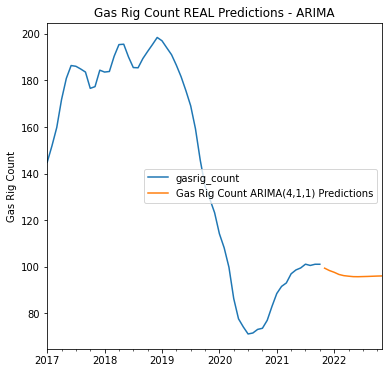

In [20]:
gas_model = ARIMA(dfgas['gasrig_count'],order=(4,1,1))
gas_results = gas_model.fit()
start=len(dfgas)
end=len(dfgas)+nobs
gas_predictions = gas_results.predict(start=start, end=end, dynamic=False, typ='levels').rename('Gas Rig Count ARIMA(4,1,1) Predictions')
# Plot predictions against known values
title = 'Gas Rig Count REAL Predictions - ARIMA'
ylabel='Gas Rig Count'
xlabel=''

ax = dfgas['gasrig_count'].loc['2017':].plot(legend=True,title=title)
gas_predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);